<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Recommendations with surprise

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-the-built-in-movielens-100k-dataset" data-toc-modified-id="Use-the-built-in-movielens-100k-dataset-1">Use the built-in movielens-100k dataset</a></span></li><li><span><a href="#Load-the-movielens-100k-dataset-from-disk" data-toc-modified-id="Load-the-movielens-100k-dataset-from-disk-2">Load the movielens-100k dataset from disk</a></span><ul class="toc-item"><li><span><a href="#Instantiate-the-algorithm" data-toc-modified-id="Instantiate-the-algorithm-2.1">Instantiate the algorithm</a></span></li><li><span><a href="#Extract-the-model-parameters" data-toc-modified-id="Extract-the-model-parameters-2.2">Extract the model parameters</a></span></li><li><span><a href="#Evaluate-the-model:" data-toc-modified-id="Evaluate-the-model:-2.3">Evaluate the model:</a></span></li><li><span><a href="#Put-the-predictions-in-a-dataframe" data-toc-modified-id="Put-the-predictions-in-a-dataframe-2.4">Put the predictions in a dataframe</a></span></li><li><span><a href="#Correlations-between-predicted-and-true-ratings" data-toc-modified-id="Correlations-between-predicted-and-true-ratings-2.5">Correlations between predicted and true ratings</a></span></li></ul></li><li><span><a href="#Cross-validation,-train-test-split-and-grid-search" data-toc-modified-id="Cross-validation,-train-test-split-and-grid-search-3">Cross validation, train-test split and grid search</a></span></li><li><span><a href="#Slope-One" data-toc-modified-id="Slope-One-4">Slope One</a></span></li><li><span><a href="#KNN-with-Means" data-toc-modified-id="KNN-with-Means-5">KNN with Means</a></span></li><li><span><a href="#Precision@k-and-Recall@k" data-toc-modified-id="Precision@k-and-Recall@k-6">Precision@k and Recall@k</a></span></li><li><span><a href="#Top-n-predictions" data-toc-modified-id="Top-n-predictions-7">Top-n predictions</a></span><ul class="toc-item"><li><span><a href="#Coverage" data-toc-modified-id="Coverage-7.1">Coverage</a></span></li><li><span><a href="#Novelty" data-toc-modified-id="Novelty-7.2">Novelty</a></span></li><li><span><a href="#Evaluate-the-similarity-of-the-top-k-predictions-between-all-pairs-of-users" data-toc-modified-id="Evaluate-the-similarity-of-the-top-k-predictions-between-all-pairs-of-users-7.3">Evaluate the similarity of the top-k predictions between all pairs of users</a></span></li><li><span><a href="#Content-data" data-toc-modified-id="Content-data-7.4">Content data</a></span><ul class="toc-item"><li><span><a href="#How-many-films-are-attributed-to-a-given-number-of-genres" data-toc-modified-id="How-many-films-are-attributed-to-a-given-number-of-genres-7.4.1">How many films are attributed to a given number of genres</a></span></li><li><span><a href="#Number-of-films-per-genre" data-toc-modified-id="Number-of-films-per-genre-7.4.2">Number of films per genre</a></span></li><li><span><a href="#Get-the-movie-titles" data-toc-modified-id="Get-the-movie-titles-7.4.3">Get the movie titles</a></span></li><li><span><a href="#Get-the-movie-genres-and-calculate-the-intra-user-diversity-based-on-movie-genre-similarity" data-toc-modified-id="Get-the-movie-genres-and-calculate-the-intra-user-diversity-based-on-movie-genre-similarity-7.4.4">Get the movie genres and calculate the intra-user diversity based on movie genre similarity</a></span></li></ul></li></ul></li></ul></div>

In this lab we will make use of the [surprise package](https://surprise.readthedocs.io/en/stable/index.html), a package dedicated to recommendation systems.

`conda install -c conda-forge scikit-surprise`

First we will need some data. Load the built-in dataset. It will have to be downloaded first.
It is a very famous dataset about movie ratings.

In [1]:
#from surprise import Dataset
# Load the movielens-100k dataset (download it if needed),
#data = Dataset.load_builtin('ml-100k')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# load surprise
import surprise as sur

## Use the built-in movielens-100k dataset

In [4]:
# Load the movielens-100k dataset (download it if needed),
data = sur.Dataset.load_builtin('ml-100k')

In [5]:
# We'll use the famous SVD algorithm.
algo = sur.SVD()

In [6]:
# Run 5-fold cross-validation and print results
sur.model_selection.cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5)

{'test_rmse': array([0.93518422, 0.94212438, 0.94047795, 0.93194904, 0.93913294]),
 'test_mae': array([0.73806352, 0.74288689, 0.74165273, 0.73617032, 0.73726932]),
 'fit_time': (5.2354209423065186,
  5.803877115249634,
  5.208932876586914,
  5.405524969100952,
  5.439161062240601),
 'test_time': (0.1901099681854248,
  0.19292187690734863,
  0.15017294883728027,
  0.20216107368469238,
  0.13910317420959473)}

## Load the movielens-100k dataset from disk

With the above command we could load the data in a simplified and already prepared way. As reading and preparing other files is not that straight-forward, we will rather load the file from disk.

In [7]:
df_data = pd.read_csv(
    '/Users/crahmede/.surprise_data/ml-100k/ml-100k/u.data', sep='\t', header=None)
df_data.columns = ['user_id', 'item_id', 'rating', 'timestamp']
df_data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The reader function serves to specify which columns are referring to user, items and ratings as well as the rating scale.

In [8]:
reader = sur.Reader(rating_scale=(1, 5))

In [9]:
# The columns must correspond to user id, item id and ratings (in that order).
data_1 = sur.Dataset.load_from_df(
    df_data[['user_id', 'item_id', 'rating']], reader)

### Instantiate the algorithm

In [10]:
algo = sur.SVD(random_state=1,
               biased=True,  # isolate biases
               reg_all=0.2,  # use regularisation (the same for all)
               n_epochs=20,  # number of epochs for stochastic gradient descent search
               n_factors=100  # number of factors to retain in SVD
               )

# we have to build a training set from the data
trainset_full = data_1.build_full_trainset()
# fit the model
algo.fit(trainset_full)

# we prepare a test set from the training set
trainsetfull_build = trainset_full.build_testset()
# obtain the predictions
predictions_full = algo.test(trainsetfull_build)
# evaluate the predictions
print(sur.accuracy.rmse(predictions_full, verbose=False))

0.9167802882204997


### Extract the model parameters

In [11]:
mu = algo.default_prediction()
bu = algo.bu
bi = algo.bi
pu = algo.pu
qi = algo.qi
puqi = pu.dot(qi.T)

> Note that internally surprise uses other (inner) indices for users and items than in the original data.
> The original ones are the raw indices. There are functions to translate between the two.

In [12]:
# check that we can reconstruct the predictions using the parameters
i = 10
print(predictions_full[i])
print()
uid = predictions_full[i].uid
iid = predictions_full[i].iid
u_inner = trainset_full.to_inner_uid(uid)
i_inner = trainset_full.to_inner_iid(iid)

pred_calc = mu + bu[u_inner] + bi[i_inner] + puqi[u_inner, i_inner]
print('Results agree:', predictions_full[i].est - pred_calc)

user: 196        item: 580        r_ui = 2.00   est = 3.34   {'was_impossible': False}

Results agree: 0.0


### Evaluate the model:

In [13]:
sur.accuracy.rmse(predictions_full)
sur.accuracy.mae(predictions_full);

RMSE: 0.9168
MAE:  0.7305


### Put the predictions in a dataframe

In [14]:
df_pred = pd.DataFrame([(x.r_ui, x.est) for x in predictions_full],
                       columns=['Rating', 'Predicted'])

In [15]:
# reconstruct RMSE
np.sqrt(df_pred.apply(lambda x: (x[0]-x[1])**2, axis=1).mean())

0.9167802882205027

In [16]:
# reconstruct MAE
df_pred.apply(lambda x: abs(x[0]-x[1]), axis=1).mean()

0.7305196298517427

### Correlations between predicted and true ratings

In [17]:
df_pred.corr(method='pearson')

,Rating,Predicted
Rating,1.000000,0.591973
Predicted,0.591973,1.000000


In [18]:
df_pred.corr(method='spearman')

,Rating,Predicted
Rating,1.000000,0.576486
Predicted,0.576486,1.000000


In [19]:
df_pred.corr(method='kendall')

,Rating,Predicted
Rating,1.000000,0.451749
Predicted,0.451749,1.000000


## Cross validation, train-test split and grid search

Example from https://surprise.readthedocs.io/en/stable/FAQ.html?highlight=raw_ratings

In [20]:
import random

raw_ratings = data_1.raw_ratings
np.random.seed(1)
# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

print(len(A_raw_ratings))
print(len(B_raw_ratings))

data_1.raw_ratings = A_raw_ratings  # data is now the set A

90000
10000


In [21]:
len(data_1.raw_ratings)

90000

In [22]:
algo = sur.SVD(random_state=1)

In [23]:
cv_results = sur.model_selection.cross_validate(
    algo, data_1, measures=['RMSE', 'MAE'], cv=5)
pd.DataFrame(cv_results)

,test_rmse,test_mae,fit_time,test_time
0,0.943043,0.744121,5.723650,0.333379
1,0.938805,0.740225,5.450951,0.125173
2,0.937366,0.737817,4.585610,0.138117
3,0.934616,0.737751,4.608500,0.179939
4,0.950216,0.749124,4.510411,0.212016


In [24]:
# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = sur.model_selection.GridSearchCV(sur.SVD,
                                               param_grid,
                                               measures=['rmse'],
                                               cv=3,
                                               refit=True)
grid_search.fit(data_1)

algo = grid_search.best_estimator['rmse']

# retrain on the whole set A
trainset = data_1.build_full_trainset()
algo.fit(trainset)

# Compute score on training set
trainset_build = trainset.build_testset()
predictions_train = algo.test(trainset_build)
print('Training score ', end='   ')
sur.accuracy.rmse(predictions_train)

# Compute score on rated test set
testset = data_1.construct_testset(B_raw_ratings)  # testset is now the set B
predictions_test = algo.test(testset)
print('Test score (rated items) ', end=' ')
sur.accuracy.rmse(predictions_test)

# Compute score on unrated data
# The anti-test set is the part where we did not have any ratings
no_ratings = trainset.build_anti_testset()
predictions_no_ratings = algo.test(no_ratings)
print('Test score (unrated items) ', end='   ')
sur.accuracy.rmse(predictions_no_ratings, verbose=False)

Grid Search...
Training score    RMSE: 0.8393
Test score (rated items)  RMSE: 0.9441
Test score (unrated items)    

0.520648834921599

In [25]:
print(len(trainset_build), len(testset), len(no_ratings))

90000 10000 1481981


In [26]:
print(predictions_train[0])
print(predictions_test[0])
print(predictions_no_ratings[0])

user: 694        item: 705        r_ui = 5.00   est = 4.48   {'was_impossible': False}
user: 401        item: 535        r_ui = 2.00   est = 2.63   {'was_impossible': False}
user: 694        item: 281        r_ui = 3.53   est = 3.36   {'was_impossible': False}


In [27]:
# extract model parameters
mu = algo.default_prediction()
print(f'Training set mean: {mu:.6}')
bu = algo.bu
bi = algo.bi
pu = algo.pu
qi = algo.qi
puqi = pu.dot(qi.T)

Training set mean: 3.52942


In [28]:
# reconstruct predictions
i = 10
print(predictions_train[i])
print()
uid = predictions_train[i].uid
iid = predictions_train[i].iid
u_inner = trainset.to_inner_uid(uid)
i_inner = trainset.to_inner_iid(iid)

pred_calc = mu + bu[u_inner] + bi[i_inner] + puqi[u_inner, i_inner]
print('Results agree:', predictions_train[i].est - pred_calc)

user: 694        item: 661        r_ui = 5.00   est = 4.58   {'was_impossible': False}

Results agree: 0.0


## Slope One

Repeat the same steps with the slope one model.

In [29]:
algo = sur.SlopeOne()

In [30]:
algo.fit(trainset)
# Compute biased accuracy on A
predictions_train = algo.test(trainset_build)
print('Biased accuracy on A,', end='   ')
sur.accuracy.rmse(predictions_train)

# Compute unbiased accuracy on B
predictions_test = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
sur.accuracy.rmse(predictions_test)

# Compute biased accuracy on A
predictions_no_ratings = algo.test(no_ratings)
print('Biased accuracy on C,', end='   ')
sur.accuracy.rmse(predictions_no_ratings, verbose=False)

Biased accuracy on A,   RMSE: 0.8456
Unbiased accuracy on B, RMSE: 0.9434
Biased accuracy on C,   

0.9439367063943614

## KNN with Means

Repeat the same steps with the kNN with means model.

In [31]:
algo = sur.KNNWithMeans()

In [32]:
algo.fit(trainset)
# Compute biased accuracy on A
predictions_train = algo.test(trainset_build)
print('Biased accuracy on A,', end='   ')
sur.accuracy.rmse(predictions_train)

# Compute unbiased accuracy on B
predictions_test = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
sur.accuracy.rmse(predictions_test)

# Compute biased accuracy on A
predictions_no_ratings = algo.test(no_ratings)
print('Biased accuracy on C,', end='   ')
sur.accuracy.rmse(predictions_no_ratings, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.7661
Unbiased accuracy on B, RMSE: 0.9452
Biased accuracy on C,   

0.7846173636934938

In [33]:
# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = sur.model_selection.GridSearchCV(sur.KNNWithMeans,
                                               param_grid,
                                               measures=['rmse'],
                                               cv=3,
                                               refit=True)
grid_search.fit(data_1)

algo = grid_search.best_estimator['rmse']

# retrain on the whole set A
trainset = data_1.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
trainset_build = trainset.build_testset()
predictions_train = algo.test(trainset_build)
print('Biased accuracy on A,', end='   ')
sur.accuracy.rmse(predictions_train)

# Compute unbiased accuracy on B
testset = data_1.construct_testset(B_raw_ratings)  # testset is now the set B
predictions_test = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
sur.accuracy.rmse(predictions_test)

# Compute biased accuracy on A
no_ratings = trainset.build_anti_testset()
predictions_no_ratings = algo.test(no_ratings)
print('Biased accuracy on C,', end='   ')
sur.accuracy.rmse(predictions_no_ratings, verbose=False)

Grid Search...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

0.7846173636934938

## Precision@k and Recall@k

Obtain  precision@k and recall@k following the [example](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k).

In [34]:
from collections import defaultdict


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    f1s = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

        # F1@K:
        f1s[uid] = 2*precisions[uid]*recalls[uid] / \
            (precisions[uid]+recalls[uid]
             ) if (precisions[uid]+recalls[uid]) != 0 else 1

    return precisions, recalls, f1s

In [35]:
precisions, recalls, f1s = precision_recall_at_k(
    predictions_train, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

0.9980381760339343
0.12778875454530952
0.2099742202300109


In [36]:
precisions, recalls, f1s = precision_recall_at_k(
    predictions_test, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

0.908918918918919
0.3357157517181557
0.4029775695759669


## Top-n predictions

Obtain the n top-ranked predictions for each user following the [example](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user).

In [37]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [38]:
top_n = {}

In [39]:
top_n = get_top_n(predictions_train, n=10)

In [40]:
len(top_n.keys())

943

In [41]:
top_n_list = []
for key in top_n.keys():
    for val in top_n[key]:
        top_n_list.append([key, val[0], val[1]])

In [42]:
len(top_n_list)

9430

In [43]:
df_top = pd.DataFrame(top_n_list, columns=['uid', 'iid', 'est'])
df_top.head()

,uid,iid,est
0,694,483,5.0
1,694,50,5.0
2,694,318,5.0
3,694,172,5.0
4,694,127,5.0


In [44]:
df_top.shape

(9430, 3)

### Coverage

Calculate the coverage of the top-ranked recommendations

In [45]:
len(df_top.iid.unique())/1682

0.32401902497027346

### Novelty

Calculate the novelty of the top-ranked recommendations.

In [46]:
df_top['iid_offset'] = df_top.iid+1000

Name: 
Type: Graph
Number of nodes: 1488
Number of edges: 9430
Average degree:  12.6747
Novelty: 104.92958642629904


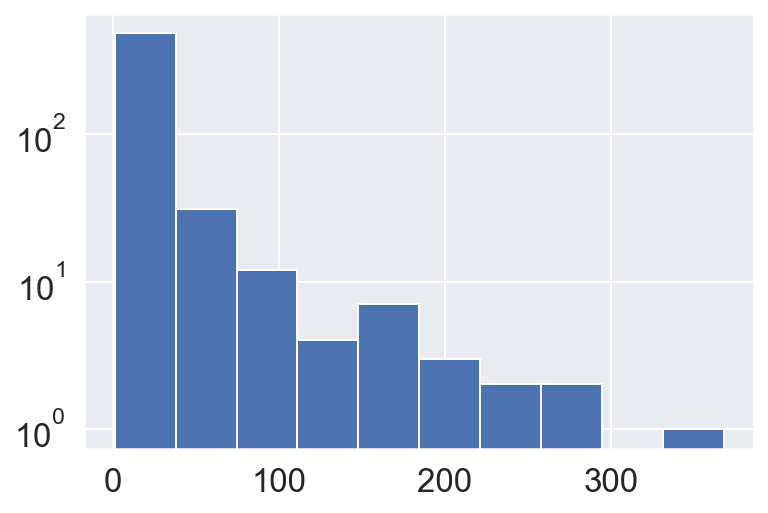

In [47]:
import networkx as nx
from networkx.algorithms import bipartite

G = nx.Graph()

G.add_nodes_from(df_top['uid'], bipartite=0)
G.add_nodes_from(df_top['iid_offset'], bipartite=1)
G.add_edges_from(df_top[['uid', 'iid_offset']].values)

print(nx.info(G))

grouped = df_top.groupby('uid')['iid_offset']
print('Novelty:', grouped.apply(lambda x: G.degree(x)).apply(
    lambda x: np.mean([xx[1] for xx in x])).mean())

plt.hist([x[1] for x in list(dict(G.degree()).items()) if x[0] > 1000])
plt.yscale('log')
plt.show()

### Evaluate the similarity of the top-k predictions between all pairs of users

Form a user-item matrix with ones indicating the top movies recommended to each user.
Use scipy's `pdist` function to calculate the similarities of all pairs of rows.



In [48]:
from scipy import sparse
from scipy.spatial.distance import pdist

In [49]:
A = sparse.csc_matrix(
    (np.ones(len(df_top)), (df_top.uid.values-1, df_top.iid.values-1)))

In [50]:
distances = pdist(A.toarray(), metric='cosine')
distances.shape

(444153,)

In [51]:
distances.mean()

0.8896713519890669

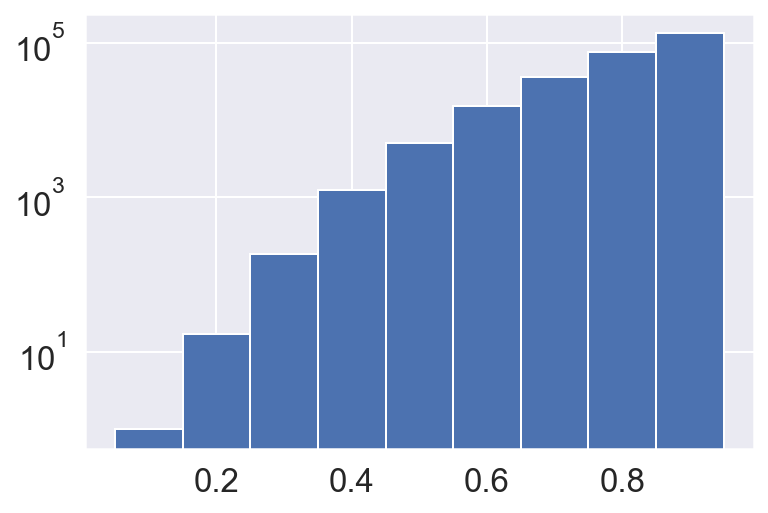

In [52]:
plt.hist(distances, bins=np.arange(0.05, 1.05, 0.1))
plt.yscale('log')
plt.show()

In [53]:
distances = pdist(A.T.toarray()+10**(-16), metric='cosine')
distances.shape

(1365378,)

In [54]:
distances.mean()

0.5065174403599567

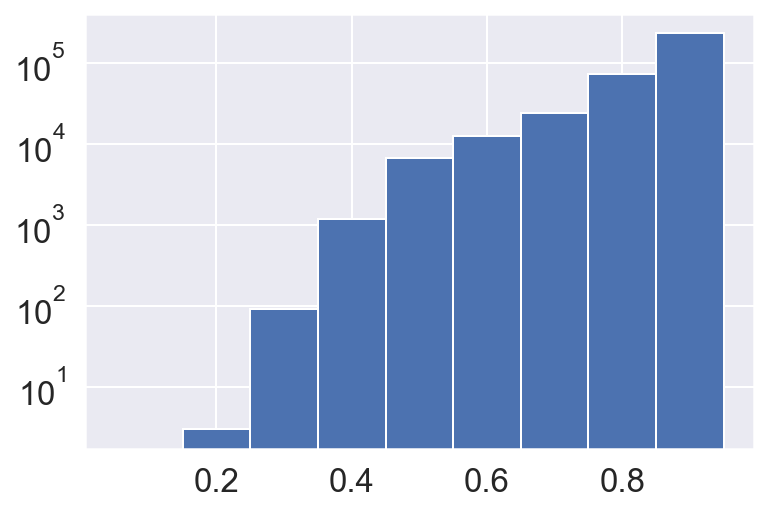

In [55]:
plt.hist(distances, bins=np.arange(0.05, 1.05, 0.1))
plt.yscale('log')
plt.show()

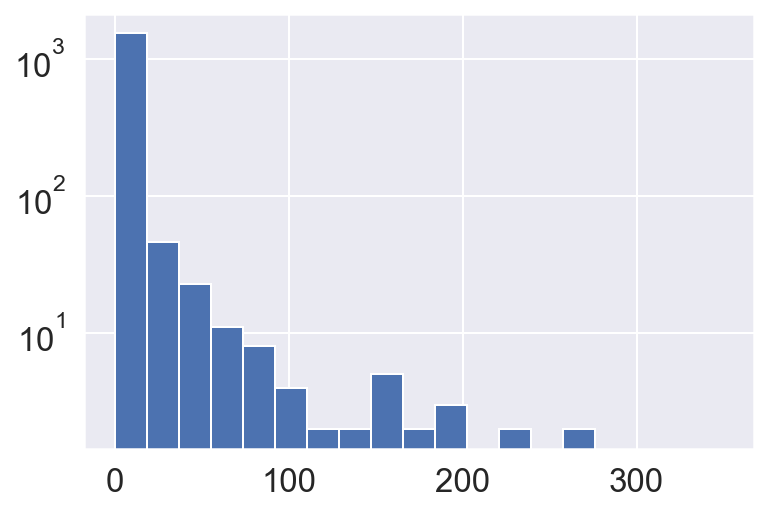

In [56]:
plt.hist(A.sum(axis=0).A1, bins=np.linspace(0, 350, 20))
plt.yscale('log')
plt.show()

### Content data

Now work with the further data files containing content information. They can be found in 

`.surprise_data/ml-100k/ml-100k/u.item`

`.surprise_data/ml-100k/ml-100k/u.user`

Take the movie data into account to evaluate the similarity of the recommended films regarding genre. 


Translate the recommended movie ids into movie titles.

In [57]:
df_users = pd.read_csv(
    '/Users/crahmede/.surprise_data/ml-100k/ml-100k/u.user', sep='|', header=None)
df_users.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
df_users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [58]:
df_items = pd.read_csv('/Users/crahmede/.surprise_data/ml-100k/ml-100k/u.item',
                       sep='|', header=None, encoding='latin')
df_items.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
                    'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                    'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                    'FilmNoir', 'Horror', 'Musical', 'Mystery', 'Romance', 'SciFi',
                    'Thriller', 'War', 'Western']
df_items.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,FilmNoir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### How many films are attributed to a given number of genres

In [59]:
df_items.loc[:, 'Action':].sum(axis=1).value_counts()

1    831
2    569
3    215
4     51
5     11
6      3
0      2
dtype: int64

#### Number of films per genre

In [60]:
df_items.loc[:, 'unknown':].sum(axis=0)

unknown          2
Action         251
Adventure      135
Animation       42
Children       122
Comedy         505
Crime          109
Documentary     50
Drama          725
Fantasy         22
FilmNoir        24
Horror          92
Musical         56
Mystery         61
Romance        247
SciFi          101
Thriller       251
War             71
Western         27
dtype: int64

In [61]:
df_items.video_release_date.unique()

array([nan])

#### Get the movie titles

In [62]:
df_items['movie_id_offset'] = (df_items.movie_id+1000)

In [63]:
df_top['titles'] = df_top.iid_offset.map(
    lambda x: df_items.movie_title[df_items.movie_id_offset == x].values[0])

In [64]:
df_top.head()

,uid,iid,est,iid_offset,titles
0,694,483,5.0,1483,Casablanca (1942)
1,694,50,5.0,1050,Star Wars (1977)
2,694,318,5.0,1318,Schindler's List (1993)
3,694,172,5.0,1172,"Empire Strikes Back, The (1980)"
4,694,127,5.0,1127,"Godfather, The (1972)"


In [65]:
df_top.groupby('uid')['titles'].get_group(2)

4950                  Titanic (1997)
4951                    Fargo (1996)
4952           Godfather, The (1972)
4953                Star Wars (1977)
4954        L.A. Confidential (1997)
4955    Sense and Sensibility (1995)
4956           Secrets & Lies (1996)
4957       As Good As It Gets (1997)
4958          Shall We Dance? (1996)
4959                     Emma (1996)
Name: titles, dtype: object

#### Get the movie genres and calculate the intra-user diversity based on movie genre similarity

In [66]:
df_genres = df_items.set_index('movie_id_offset').loc[:, 'Action':].copy()
df_genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,FilmNoir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
movie_id_offset,,,,,,,,,,,,,,,,,,
1001,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1002,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1004,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1005,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [67]:
from itertools import combinations

In [68]:
count = 0
for i in range(1001, 2000):
    if pdist(df_genres.loc[[1001, i]], metric='cosine') < 0.8:
        count += 1

In [69]:
count

358

In [70]:
pdist(df_genres.loc[[1001, i]], metric='cosine')[0]

0.42264973081037416

In [71]:
user_ids = df_top.uid.unique()

In [72]:
intra_user_sim = []
for user in user_ids:
    intra_user_sim.append(np.mean([pdist(df_genres.loc[[comb[0], comb[1]]], metric='cosine')[
                          0] for comb in combinations(df_top.iid_offset[df_top.uid == user].tolist(), 2)]))

In [73]:
len(intra_user_sim)

943

In [74]:
pd.Series(intra_user_sim).mean()

0.6733519992119862